In [1]:
from imports import*
from model_config import*
from utility_new import*
from utility import*
import tensorflow as tf

Using TensorFlow backend.
/home/tabasher/myenv/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/tabasher/myenv/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/tabasher/myenv/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/tabasher/myenv/lib/python3.5/site-packages/tensorflow/py

# Trainer class to train VGG16 model 

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Thu Mar 19 15:51:28 2020

@author: IBM
"""

from utility import config_list, update_model, update_conifg
import numpy as np
from keras.datasets import cifar10
import keras
from keras.preprocessing.image import ImageDataGenerator

from keras import optimizers
import numpy as np
from keras.layers.core import Lambda
from keras import backend as K
batch_size = 128
maxepoches = 100
learning_rate = 0.0001 # 0.0001
lr_decay = 1e-6
lr_drop = 20

class trainer:
    def __init__(self,model_new,saving_best_acc_name,final_model_save,train=True):
        self.num_classes = 10
        self.weight_decay = 0.0005
        self.x_shape = [32,32,3]
        
#         filters=[59, 53, 119, 128, 227, 256, 256, 512, 314, 402, 418, 385, 512]

        #self.model = self.build_model()
        if train:
            # config= config_list()
            # config=update_conifg(filters=filters_cfg)
            # self.model=update_model(config)
            # self.model.load_weights(current_model_name)
            model_new = self.train(model_new,saving_best_acc_name,final_model_save)
        else:
            self.model.load_weights('cifar10vgg.h5')


    def normalize(self,X_train,X_test):
        #this function normalize inputs for zero mean and unit variance
        # it is used when training a model.
        # Input: training set and test set
        # Output: normalized training set and test set according to the trianing set statistics.
        mean = np.mean(X_train,axis=(0,1,2,3))
        std = np.std(X_train, axis=(0, 1, 2, 3))
        X_train = (X_train-mean)/(std+1e-7)
        X_test = (X_test-mean)/(std+1e-7)
        return X_train, X_test

    def normalize_production(self,x):
        #this function is used to normalize instances in production according to saved training set statistics
        # Input: X - a training set
        # Output X - a normalized training set according to normalization constants.

        #these values produced during first training and are general for the standard cifar10 training set normalization
        mean = 120.707
        std = 64.15
        return (x-mean)/(std+1e-7)

    def predict(self,x,normalize=True,batch_size=50):
        if normalize:
            x = self.normalize_production(x)
        return self.model.predict(x,batch_size)

    def train(self,model,saving_best_acc_name,final_model_save):
        print ('Total Params = ',model.count_params())

        #training parameters
        
        # The data, shuffled and split between train and test sets:
        (x_train, y_train), (x_test, y_test) = cifar10.load_data()
        x_train = x_train.astype('float32')
        x_test = x_test.astype('float32')
        x_train, x_test = self.normalize(x_train, x_test)
        y_train = np.reshape(y_train,(len(y_train),))
        y_test = np.reshape(y_test,(len(y_test),))

        y_train = keras.utils.to_categorical(y_train, self.num_classes)
        y_test = keras.utils.to_categorical(y_test, self.num_classes)

        def lr_scheduler(epoch):
            return learning_rate * (0.5 ** (epoch // lr_drop))
        reduce_lr = keras.callbacks.LearningRateScheduler(lr_scheduler)
        
        checkpoint=keras.callbacks.ModelCheckpoint(saving_best_acc_name,
                                             monitor='val_acc', verbose=1,
                                              save_best_only=True,
                                             mode='auto')

        #data augmentation
        datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
            width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False)  # randomly flip images
        # (std, mean, and principal components if ZCA whitening is applied).
        datagen.fit(x_train)



        #optimization details
        sgd = optimizers.SGD(lr=learning_rate, 
                             momentum=0.9, nesterov=True)
        model.compile(loss='categorical_crossentropy',
                      optimizer=sgd,metrics=['accuracy'])


        # training process in a for loop with learning rate drop every 25 epoches.

        historytemp = model.fit_generator(datagen.flow(x_train, y_train,
                                         batch_size=batch_size),
                            steps_per_epoch=x_train.shape[0] // batch_size,
                            epochs=maxepoches,
                            validation_data=(x_test, y_test),callbacks=[checkpoint],verbose=1)
        model.save_weights(final_model_save)
        return model

# Loading CIFAR10 dataset

In [2]:
# %%  Loading Data 

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train = np.reshape(y_train,(len(y_train),))
y_test = np.reshape(y_test,(len(y_test),))
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

x_test = normalize_production(x_test)
xx_train = normalize_production(x_train)


In [3]:
x_test=x_test[0:100]
y_test=y_test[0:100]

In [4]:
total_conv_filters=4224  # total conv filters
USE_CUDA=False
csv_folder_name = 'prune_stats'
if not os.path.isdir(csv_folder_name): 
    print("Folder is not present , making a folder")
    os.mkdir(csv_folder_name)
csv_file_name = 'pruning_stats.csv'
csv_file_address = os.path.join(csv_folder_name,csv_file_name)

if not os.path.isfile(csv_file_address):
    print ("File is not present")
    print ("Address = ", csv_file_address)
    Heading = ['params Pruned (%)','Accuracy without retrain(%)', 'Filters Left', 'Params Left', 'Config', 
              'Filters removed in each iteration','Layers in each itration',
              'Accuracy in each iteration']
    with open (csv_file_address,'w') as stats_file: 
        writer = csv.writer(stats_file)
        writer.writerow(Heading)

In [5]:
x_list=[0.005*i*10 for i in range(1,5)]
delta_A = 1    
previous_pruning_ratio=0
pruning_ratio = 15
previous_model_name='prune_models/model_prune_'+str(previous_pruning_ratio)+'.h5'
current_model_name='prune_models/model_prune_VGG16_GLB64'+str(pruning_ratio)+'.h5'

In [6]:
with tf.device("cpu:0"):
    after_retrain = False 
    if after_retrain:
        config = config_list()
        saving_best_acc_name='train_models/best_acc_model_60.03.h5'
        config = update_conifg(filters=conv_filters_left)
        model = update_model(config)
        model.load_weights(saving_best_acc_name)
    else:
        config = config_list()
        filters_n=[64, 64, 128, 128, 256, 256, 256, 512, 512, 512, 512, 512, 512]
        config = update_conifg(filters=filters_n)
        model = update_model(config)
        model.load_weights(previous_model_name)
    #     model.load_weights(previous_model_name)

    prev_acc = accuracy(x_test,y_test,model)
    print ("Accuracy of Baseline = ", prev_acc)

100/100 [==============================] - 1s 6ms/step
Accuracy of Baseline =  96.0


In [ ]:
# ===================================================================
total_conv_filters=4224
conv_indices=get_conv_layer_indices(model) # conv layer indices
[conv_filters_orig,conv_filters_left]=get_model_filters(model,conv_indices)
total_params = get_conv_filters_params(filters_list=conv_filters_orig)
params_pruned = int(round((pruning_ratio/100)*total_params))
total_params_required = total_params-params_pruned
print("Total number of parameters need to be removed = ",params_pruned)


iteration=1
layer_selected_each_step=[]
filters_removed_each_step=[]
accuracy_each_step=[]
start_time = time.time()


# Step 1: 
###  Plot senstivilty of each layer towards pruning

In [8]:
# sentivity analysis 

In [12]:
model_prev = update_model(config)
model_prev.set_weights(model.get_weights()) # saving weights of previous iteration 
scores=saliency_measure_l2_norm(model,conv_indices) # importance of each 3D filter 
# acc_all_layers=senstivity_analysis(model,model_prev,conv_indices,scores,x_test,y_test)

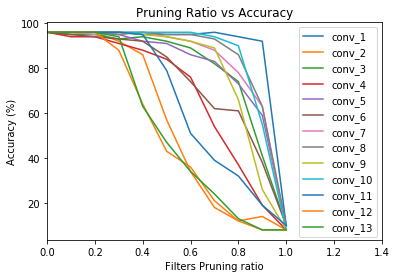

In [25]:
ratios=[i*0.1 for i in range(0,11)]
plot_sensitivity_analysis(acc_all_layers,ratios)

# Step 2:
### Estimate pruning ratio for each layer by seeing senstivity analysis 

In [9]:
prune_ratios=[0.5 for i in range(len(conv_filters_orig))]

# Step 3:
### Remove filters from each layer in single shot according to pre-defined pruning ratio of each layer 

In [10]:
# remove filters for pre-defined ratio (each layer)

In [13]:
last=False
for i,r in enumerate(prune_ratios):
    layer_index = conv_indices[i][1]
    if (layer_index==conv_indices[-1][1]):
        next_layer_index=layer_index+5
        last=True
    else:
        next_layer_index=conv_indices[i+1][1]
    score=scores[i]
    model=modify_model_weights(model,layer_index,next_layer_index,r,score,last)
[model_new,model_temp] = make_pruned_model(model,conv_indices)



# Step 4:
### Calculate the pruning ratio and update model configuration file

In [24]:
pr=100.0*((model.count_params()-model_new.count_params())/model.count_params())
print ("pruning ratio = ",pr)
[filters_new,_]=get_model_filters(model_new,conv_indices)
config=update_conifg(filters_new)

pruning ratio =  74.48661186562498


# Step 5: 
### Retrain the pruned model to regain the lost accuracy 

In [35]:
saving_best_acc_name = 'best_acc_prune_'+ str('%.2f'%pr)+'.h5'
final_model_save = 'final_acc_prune_'+str('%.2f'%pr)+'.h5'
model = trainer(model_new,saving_best_acc_name,final_model_save)

In [36]:
# Repeat step 1 to 5 to further pruningl 

best_acc_prune_74.49.h5
final_acc_prune_74.49.h5
